# Анализ товарных категорий

<b>Комментарии к данным:</b>

- Ship Mode: Mode of shipping used for shipment delivery

- Segment: (Categorical) Customer segment product was shipped to

- Country: Country in which the shipment was delivered

- City: City in which shipment was delivered

- State: State in which the shipment was delivered

- Postal Code: Postal code the shipment was delivered to

- Region: Country region

- Category: The category product belongs to

- Sub-Category: Sub-category of the product

- Month: Month of Sales/Profit

### Задача 1.  
Построить графики, которые покажут category товаров с наибольшей прибылью.  
Проанализировать sub-categories такой категории. в т.ч. во временно динамике.  

In [7]:
# Загружаем библиотеки.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import t
from math import sqrt
import seaborn as sns


In [8]:
# Читаем данные:

df = pd.read_csv('https://raw.githubusercontent.com/zhukov-analyst/portfolio/main/python/data/StoreMarketplace.csv', sep=',')

In [9]:
# Проверяем данные на анамалии и изучаем для выстраивания дальнейшей логики работы.

def describe_data(df):
    display(df.head(10))
    print('---------------------------------------------------')
    print(df.info())
    print('---------------------------------------------------')
    print(df.describe())
    print('---------------------------------------------------')
    print('Уникальные значения:')
    print(df.describe(include='all').loc['unique', :])
    print('---------------------------------------------------')
    print('Пропуски:')
    print(df.isna().sum())
    print('---------------------------------------------------')
    print('Дубликаты:', df.duplicated().sum())
    print()

describe_data(df)

,Ship Mode,Segment,Country,City,State,Postal Code,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit,Month
0,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Bookcases,261.9600,2,0.00,41.9136,1
1,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Chairs,731.9400,3,0.00,219.5820,3
2,Second Class,Corporate,United States,Los Angeles,California,90036,West,Office Supplies,Labels,14.6200,2,0.00,6.8714,1
3,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Furniture,Tables,957.5775,5,0.45,-383.0310,12
4,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Office Supplies,Storage,22.3680,2,0.20,2.5164,6
5,Standard Class,Consumer,United States,Los Angeles,California,90032,West,Furniture,Furnishings,48.8600,7,0.00,14.1694,1
6,Standard Class,Consumer,United States,Los Angeles,California,90032,West,Office Supplies,Art,7.2800,4,0.00,1.9656,11
7,Standard Class,Consumer,United States,Los Angeles,California,90032,West,Technology,Phones,907.1520,6,0.20,90.7152,4
8,Standard Class,Consumer,United States,Los Angeles,California,90032,West,Office Supplies,Binders,18.5040,3,0.20,5.7825,7
9,Standard Class,Consumer,United States,Los Angeles,California,90032,West,Office Supplies,Appliances,114.9000,5,0.00,34.4700,8


---------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Ship Mode     9994 non-null   object 
 1   Segment       9994 non-null   object 
 2   Country       9994 non-null   object 
 3   City          9994 non-null   object 
 4   State         9994 non-null   object 
 5   Postal Code   9994 non-null   int64  
 6   Region        9994 non-null   object 
 7   Category      9994 non-null   object 
 8   Sub-Category  9994 non-null   object 
 9   Sales         9994 non-null   float64
 10  Quantity      9994 non-null   int64  
 11  Discount      9994 non-null   float64
 12  Profit        9994 non-null   float64
 13  Month         9994 non-null   int64  
dtypes: float64(3), int64(3), object(8)
memory usage: 1.1+ MB
None
---------------------------------------------------
        Postal Code         Sales 

In [10]:
# посмотрим на уникальные значения в кажом столбце 

import pandas as pd
from IPython.display import display

pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 300)

df_info = pd.DataFrame(df.describe(include='all').loc['unique', :])
df_info['type'] = pd.Series(list(df.dtypes),index=df.columns)
df_info['value'] = pd.Series(list(map(set,df.values.T)),index=df.columns)

display(df_info)

,unique,type,value
Ship Mode,4,object,"{First Class, Standard Class, Second Class, Same Day}"
Segment,3,object,"{Home Office, Corporate, Consumer}"
Country,1,object,{United States}
City,531,object,"{Lafayette, Trenton, Mcallen, Cary, Everett, Alexandria, College Station, Nashville, Lakeland, Ontario, Santa Clara, Monroe, Long Beach, Las Cruces, Wausau, Bossier City, Boynton Beach, Tulsa, Eau..."
State,49,object,"{Michigan, North Dakota, Utah, Idaho, Maryland, Florida, Tennessee, Alabama, Indiana, Minnesota, Delaware, Kentucky, South Carolina, Mississippi, Vermont, South Dakota, Missouri, New York, Oklahom..."
Postal Code,NaN,int64,"{32771, 43017, 59405, 77840, 79907, 88101, 47150, 43055, 49201, 84020, 57401, 32839, 84041, 55369, 84043, 92236, 82001, 41042, 84057, 2138, 92253, 84062, 47201, 2148, 2149, 2151, 8302, 55407, 4312..."
Region,4,object,"{Central, South, East, West}"
Category,3,object,"{Technology, Office Supplies, Furniture}"
Sub-Category,17,object,"{Accessories, Chairs, Phones, Storage, Supplies, Bookcases, Copiers, Furnishings, Tables, Binders, Labels, Appliances, Machines, Paper, Art, Fasteners, Envelopes}"
Sales,NaN,float64,"{2.628, 3.75, 4.616, 5.0, 5.5, 6.0, 8.75, 8.64, 8.39, 9.64, 10.89, 13.0, 14.75, 15.25, 10.64, 9.14, 18.75, 11.64, 20.0, 21.5, 22.72, 23.92, 22.75, 23.976, 24.0, 26.25, 22.0, 29.0, 30.0, 26.0, 31.5..."


В данных имеется три полных повтора - невозможно точно сказать в связи с чем это связано. Повторов слишком мало, поэтому с ними можно ничего не делать.  

В остальном с данными всё поряке. Все форматы данных соответствуют содержанию.  
Можно работать дальше.

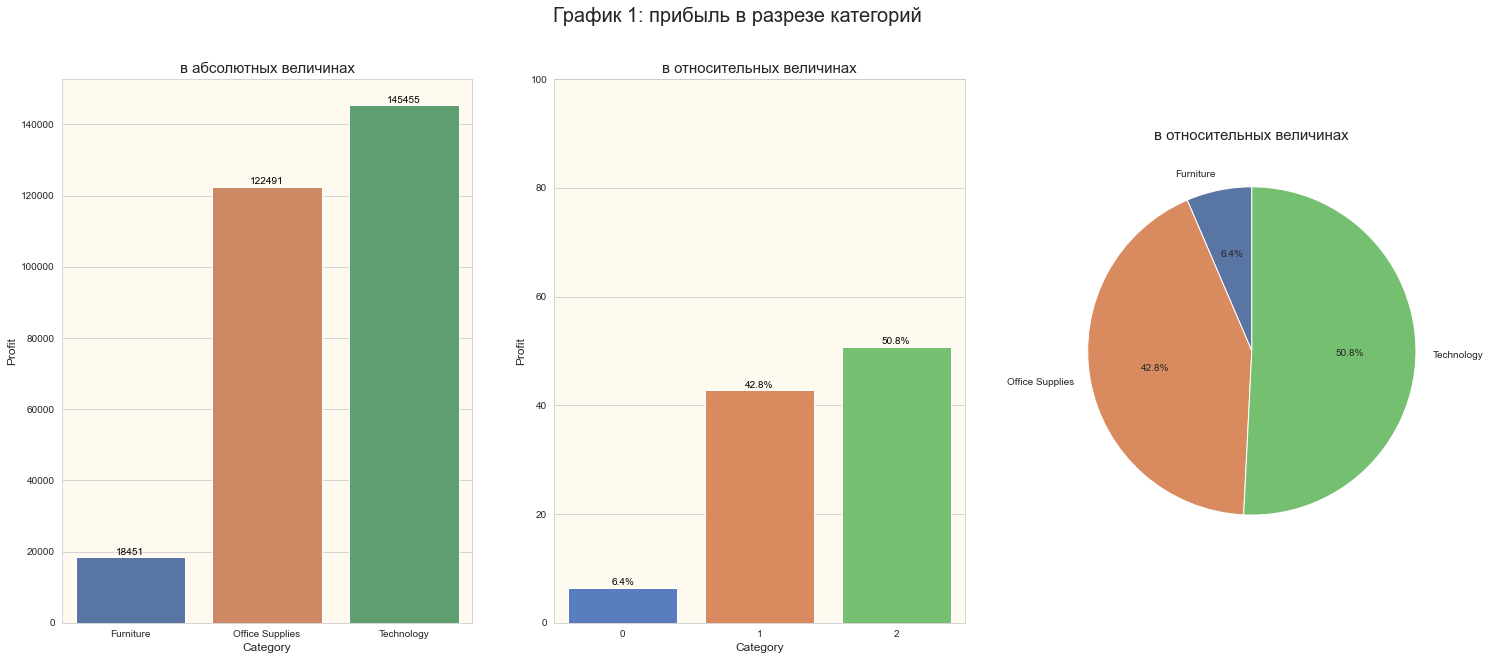

In [19]:
# Построим графики категорий совокупно за весь период.

fig, axes = plt.subplots(1, 3, figsize=(25, 10))
plt.suptitle('График 1: прибыль в разрезе категорий', fontsize=20)
sns.set_style('whitegrid', {'axes.facecolor': 'floralwhite', 'axes.grid': True})

# график в абсолютных величинах.
sns.barplot(ax=axes[0], x='Category', y='Profit', data = df, orient = 'v', ci = None, estimator = sum, palette ='deep')

for p in axes[0].patches:
    axes[0].annotate('{:.0f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
    textcoords='offset points')

axes[0].set_title('в абсолютных величинах', fontsize=15)
axes[0].set_xlabel('Category', fontsize=12)
axes[0].set_ylabel('Profit', fontsize=12)
axes[0].tick_params(labelsize = 10)


# график в относительных величинах.
data_per = df.groupby('Category', as_index=False).agg(percentage =('Profit', lambda p: p.sum() / df['Profit'].sum() * 100)).round(2)
sns.barplot(ax=axes[1],x=data_per.index, y='percentage', data=data_per, ci=None, palette="muted",orient='v')

axes[1].set_title('в относительных величинах', fontsize=15)
axes[1].set_xlabel('Category', fontsize=12)
axes[1].set_ylabel('Profit', fontsize=12)
axes[1].tick_params(labelsize = 10)

for rect in axes[1].patches:
    axes[1].annotate("%.1f%%" % rect.get_height(), (rect.get_x() + rect.get_width() / 2, rect.get_height()), 
    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
    textcoords='offset points')
axes[1].set(ylim=(0, 100))


# круговая диаграмма категорий в относительных величинах.
data_per_list = data_per['percentage'].to_list()
category = data_per['Category'].unique()
colors = ['#5975a4','#d98b5f','#75bf71']

axes[2].pie(x=data_per_list, labels=category, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=colors)
axes[2].set_title('в относительных величинах', fontsize=15)


plt.show()


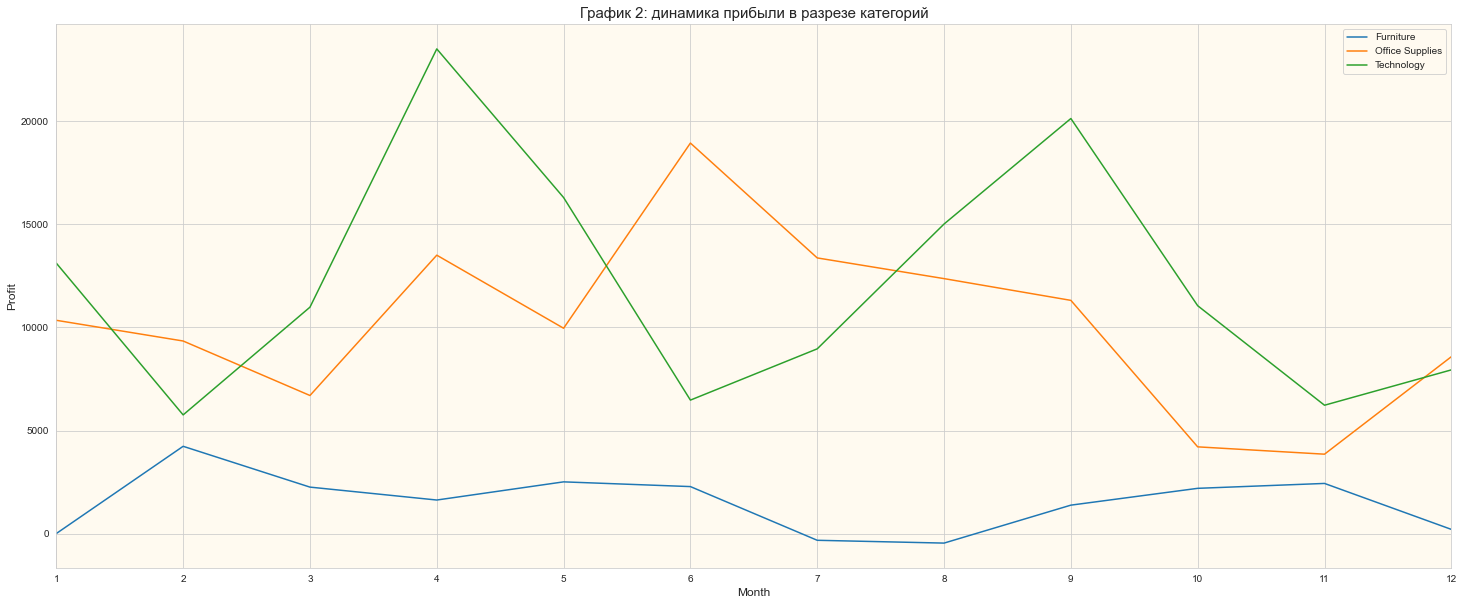

In [20]:
# Построим линейные графики категорий в разрезе месяцев.

# новый дата-фрейм только из нужных категорий + преобразование месяца в строку + агрегация данных
df_new = df[['Category', 'Profit','Month']]
df_new['Month'].apply(str)
df_new = df_new.groupby(['Category', 'Month'], as_index = False).sum().sort_values(['Category', 'Month'], ascending=[True, True], ignore_index=True)


fig, ax = plt.subplots(figsize=(25, 10))
sns.set_style('whitegrid', {'axes.facecolor': 'floralwhite', 'axes.grid': True})

categories = df_new['Category'].unique()
for i in categories:
    plt.plot(df_new[df_new['Category'] == i].groupby('Month').sum()['Profit'], label=i)
    
plt.xticks(np.arange(1, 13, 1))
ax.set_xlim(1, 12)

ax.set_title('График 2: динамика прибыли в разрезе категорий', fontsize=15)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Profit', fontsize=12)
ax.tick_params(labelsize = 10)
ax.legend()

plt.show()


### Вывод:  

Самая прибыльная категория - Technology, она генерирует больше всего прибыли.  
Однако, в динамике видна выраженная цикличность - в феврале, июне, июле, ноябре сильное падение.

### Задача 2.  
Определить для категории самый profitable, какая подкатегория вносила самый большой вклад в этом месяце (в %).

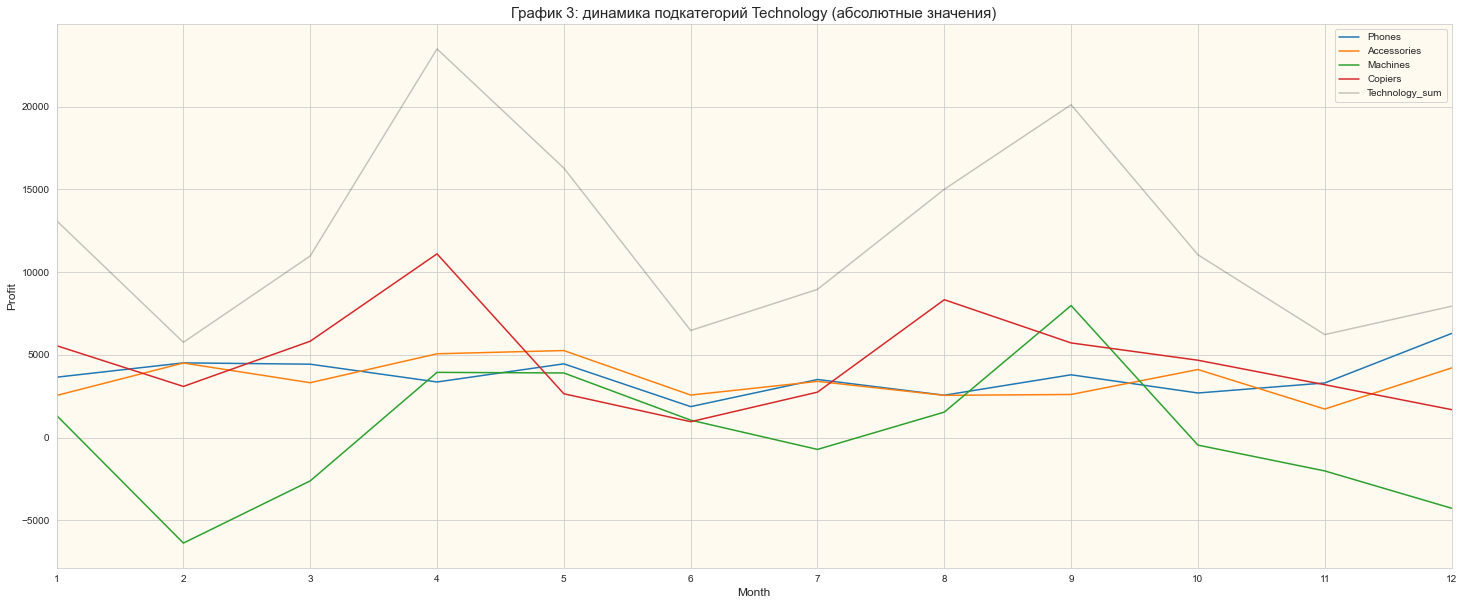

In [21]:
# Построим линейные графики подкатегорий Technology в разрезе месяцев.

# новый дата-фрейм только с Technology
df_Tech = df.loc[df['Category'] == 'Technology']


fig, ax = plt.subplots(figsize=(25, 10))
sns.set_style('whitegrid', {'axes.facecolor': 'floralwhite', 'axes.grid': True})

sub_categories = df_Tech['Sub-Category'].unique()
for i in sub_categories:
    plt.plot(df_Tech[df_Tech['Sub-Category'] == i].groupby('Month').sum()['Profit'], label=i)
plt.plot(df_Tech.groupby('Month').sum()['Profit'], label='Technology_sum', color = '#0a0b0c3a')
    
plt.xticks(np.arange(1, 13, 1))
ax.set_xlim(1, 12)

ax.set_title('График 3: динамика подкатегорий Technology (абсолютные значения)', fontsize=15)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Profit', fontsize=12)
ax.tick_params(labelsize = 10)
ax.legend()

plt.show()

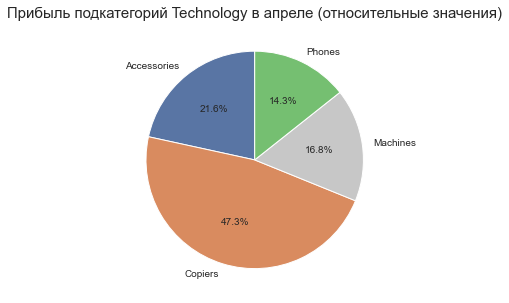

  Sub-Category  percentage
0  Accessories       21.58
1      Copiers       47.28
2     Machines       16.80
3       Phones       14.33


In [15]:
# Построим круговую диаграмму для апреля.

# новый дата-фрейм только для апреля
df_Tech_april = df_Tech.loc[df_Tech['Month'] == 4]
df_Tech_per = df_Tech_april.groupby('Sub-Category', as_index=False).agg(percentage =('Profit', lambda p: p.sum() / df_Tech_april['Profit'].sum() * 100)).round(2)


fig, ax = plt.subplots(figsize=(10, 5))

df_Tech_per_list = df_Tech_per['percentage'].to_list()
sub_categories = df_Tech_per['Sub-Category'].unique()
colors = ['#5975a4','#d98b5f','#0a0b0c3a','#75bf71']

ax.pie(x=df_Tech_per_list, labels=sub_categories, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=colors)

ax.set_title('Прибыль подкатегорий Technology в апреле (относительные значения)', fontsize=15)


plt.show()
print(df_Tech_per)

### Вывод:
Самый прибыльный месяц - апрель.  
Наибольшее влияние внесла подкатегория Copiers.

### Задача 3.  
Определить в какие месяцы топовая подкатегория не приносила больше всего profit.

In [16]:
df_Tech_sum = df_Tech.groupby(['Category','Sub-Category'], as_index = False).sum().sort_values('Profit', ascending=False)
df_Tech_sum


,Category,Sub-Category,Postal Code,Sales,Quantity,Discount,Profit,Month
1,Technology,Copiers,3873477,149528.030,234,11.0,55617.8249,416
3,Technology,Phones,47897175,330007.054,3289,137.4,44515.7306,5743
0,Technology,Accessories,44468434,167380.318,2976,60.8,41936.6357,5006
2,Technology,Machines,6364668,189238.631,440,35.2,3384.7569,740


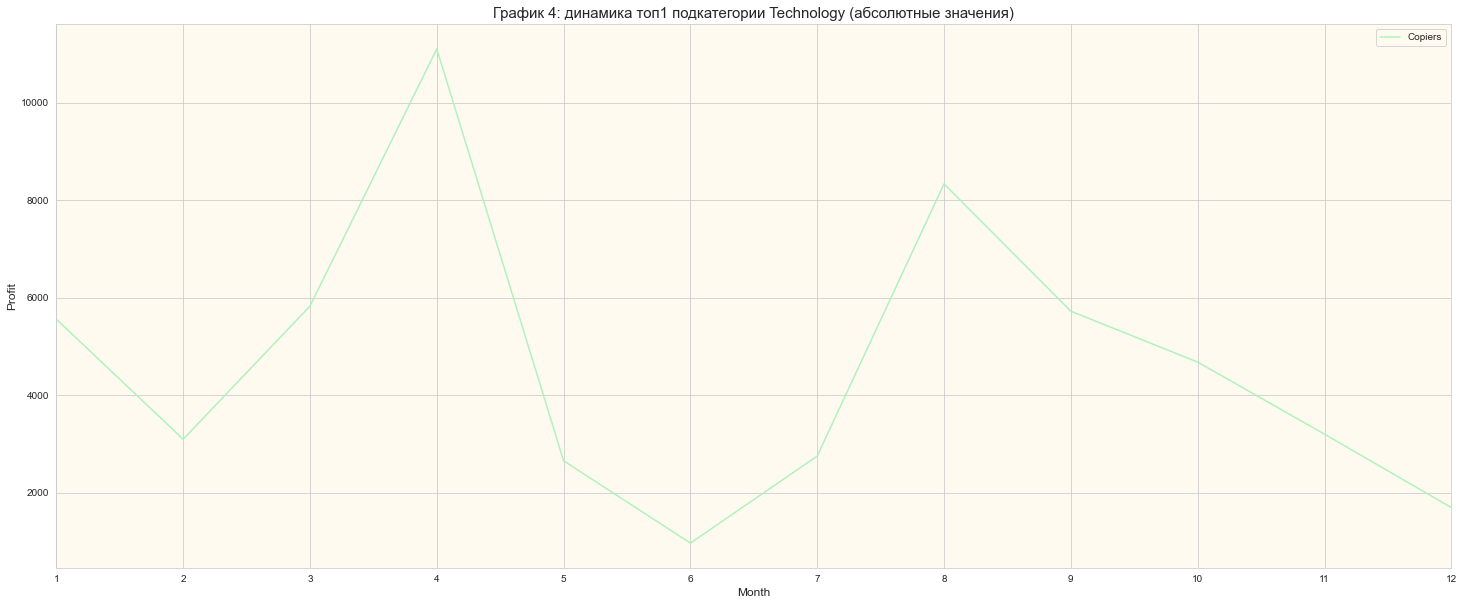

In [22]:
# Посмтрим на динамику Copiers.

fig, ax = plt.subplots(figsize=(25, 10))

sns.set_style('whitegrid', {'axes.facecolor': 'floralwhite', 'axes.grid': True})

plt.plot(df_Tech[df_Tech['Sub-Category'] == 'Copiers'].groupby('Month').sum()['Profit'], label='Copiers', color = '#b0f2bb')
    
plt.xticks(np.arange(1, 13, 1))
ax.set_xlim(1, 12)

ax.set_title('График 4: динамика топ1 подкатегории Technology (абсолютные значения)', fontsize=15)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Profit', fontsize=12)
ax.tick_params(labelsize = 10)
ax.legend()

plt.show()

### Вывод:

В июле у Copiers сильный спад.